In [1]:
"""
This test explains how to use kenkenpa by using LangGraph's "Conditional Branching" as an example.
Some parts of the test code are adapted from the code described at the following URL.
https://langchain-ai.github.io/langgraph/how-tos/branching/#conditional-branching
"""

'\nThis test explains how to use kenkenpa by using LangGraph\'s "Conditional Branching" as an example.\nSome parts of the test code are adapted from the code described at the following URL.\nhttps://langchain-ai.github.io/langgraph/how-tos/branching/#conditional-branching\n'

In [2]:
import operator
from typing import Any

from kenkenpa.builder import StateGraphBuilder

# State is not defined. It is defined within graph_settings.
# class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    # aggregate: Annotated[list, operator.add]

# Define a factory function that returns a ReturnNodeValue.
def gen_return_node_value(factory_parameter,flow_parameter):

    class ReturnNodeValue:
        def __init__(self, node_secret: str):
            self._value = node_secret

        def __call__(self, state ) -> Any:
            print(f"Adding {self._value} to {state['aggregate']}")
            return {"aggregate": [self._value]}

    object = ReturnNodeValue(factory_parameter['node_secret'])

    return object

In [3]:
# Describe the settings of a compilable StateGraph in dictionary format.
graph_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"Parallel-node",
        # The state "aggregate" is set here.
        "state" : [
            {
                "field_name": "aggregate",
                "type": "list",
                "reducer":"add"
            },
        ],
    },
    "flows": [
        { # node A
            "graph_type":"node",
            "flow_parameter": {
                "name":"a",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm A"},
        },
        { # normal_edge START-> a
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"a"
            },
        },
        { # node b
            "graph_type":"node",
            "flow_parameter": {
                "name":"b",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm B"},
        },
        { # node c
            "graph_type":"node",
            "flow_parameter": {
                "name":"c",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm C"},
        },
        { # node d
            "graph_type":"node",
            "flow_parameter": {
                "name":"d",
                "factory":"gen_return_node_value",
            },
            "factory_parameter" : {"node_secret":"I'm D"},
        },
        { # normal_edge a -> b,c
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"a",
                "end_key":["b","c"],
            },
        },
        { # normal_edge b,c -> d
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":["b","c"],
                "end_key":"d"
            },
        },
        { # normal_edge d -> END
            "graph_type":"edge",
            "flow_parameter": {
                "start_key":"d",
                "end_key":"END"
            },
        },
    ]
}

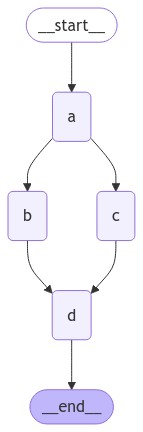

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'aggregate': ["I'm A", "I'm B", "I'm C", "I'm D"]}

In [4]:
# Generate the StateGraphBuilder from graph_settings.
stategraph_builder = StateGraphBuilder(graph_settings)

# Register the reducer to be used in the StateGraphBuilder.
stategraph_builder.add_reducer("add",operator.add)

# Register the node factory with the stategraph_builder.
stategraph_builder.add_node_factory("gen_return_node_value",gen_return_node_value)

# The gen_stategraph method generates a compilable StateGraph.
stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
graph = stategraph.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

graph.invoke({"aggregate": []}, {"configurable": {"thread_id": "foo"}})